In [226]:
# Algorithmic Harmonic Accompaniment project
# for Musical Signal Processing, Fall 2018, Johanna Devaney, Brooklyn College
# by David Elkin-Ginnetti

# N.b.: All of the audio files were too large to upload to GitHub! 
# Uncomment the IPython.display.audio messages to hear the synthesized harmonizations

In [227]:
import pretty_midi
import numpy as np
import mir_eval.display
import librosa.display
import matplotlib.pyplot as plt
%matplotlib inline
import IPython.display
import fluidsynth
#import pixiedust

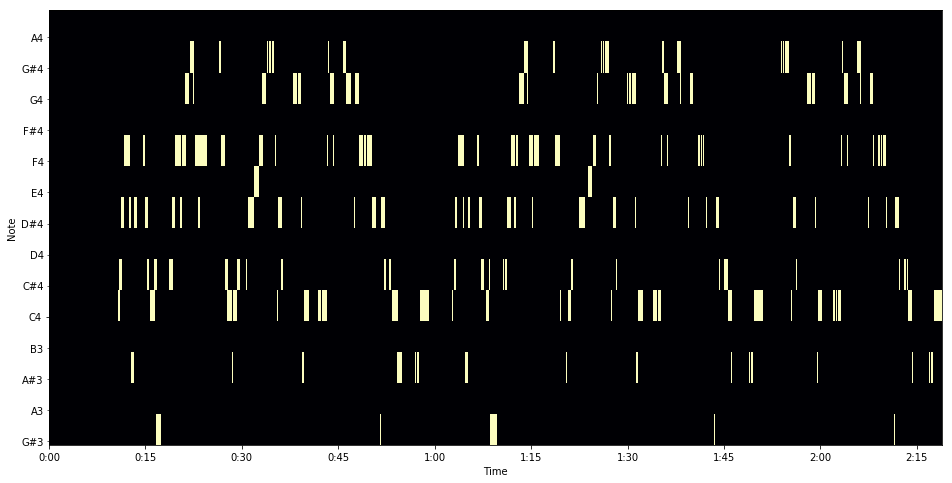

In [228]:
#One form of data visualization with the library
pm = pretty_midi.PrettyMIDI('killing_me_softly_melody.mid')
start_pitch = min(make_pitch_array(pm))
end_pitch = max(make_pitch_array(pm))

def plot_piano_roll(pm, start_pitch, end_pitch, fs=100):
    librosa.display.specshow(pm.get_piano_roll(fs)[start_pitch:end_pitch],
                             hop_length=1, sr=fs, x_axis='time', y_axis='cqt_note',
                             fmin=pretty_midi.note_number_to_hz(start_pitch))

plt.figure(figsize=(16, 8))
plot_piano_roll(pm,min(make_pitch_array(pm)),max(make_pitch_array(pm)))

In [229]:
#Returns unweighted, repeating list of all pitches in file
def make_pitch_array(pm):
    pitch_array = []
    for instrument in pm.instruments:
        if not instrument.is_drum:
            for note in instrument.notes:
                pitch_array.append(note.pitch)
    return pitch_array

In [230]:
def adjust_tempo(pm, input_tempo = 120., output_tempo = 120.):
    length = pm.get_end_time()
    scaling = output_tempo/input_tempo
    pm.adjust_times([0, length], [0, length*scaling])
    return pm

In [231]:
#Two ways to chart pitch data as proportions of pitch classes
def make_graph(pm):
    plt.xticks(np.arange(12), ['C', '', 'D', '', 'E', 'F', '', 'G', '', 'A', '', 'B'])
    plt.xlabel('Note')
    plt.ylabel('Proportion')
    return plt.bar(np.arange(12), pm.get_pitch_class_histogram());

def make_graph_weighted(pm):
    plt.xticks(np.arange(12), ['C', '', 'D', '', 'E', 'F', '', 'G', '', 'A', '', 'B'])
    plt.xlabel('Note')
    plt.ylabel('Proportion')
    return plt.bar(np.arange(12), pm.get_pitch_class_histogram(use_duration=True, use_velocity=True));

In [232]:
#  Weighting function to express probabilities of all pitches in melody,
#     scaled for velocity and duration importance

def pitch_probs(pm,inst=0):
    
    #Make the array
    pitch_list = np.ndarray(12,dtype=float)
    
    
    #Add notes with weighting
    for note in pm.instruments[inst].notes:
        note_length = note.end - note.start
        note_length_scaling = 1 # Maybe change this?
        pitch_class = note.pitch % 12
        velocity_weight = ((np.log(note.velocity))**2)/20 
            #Returns a little over 1 at max velocity; .26 at 10 velocity, etc
        total_weight = velocity_weight + (note_length * note_length_scaling)
        pitch_list[pitch_class] += total_weight
            
    
    #Turn the array into an averaged probability table
    
    total_amounts = sum(pitch_list)
    i = 0
    
    for pitch in pitch_list:
        prob = pitch / total_amounts
        pitch_list[i] = prob
        i += 1

    return pitch_list

In [233]:
#For adding probability functions in the future
def decision(prob):
    if np.random.random() <= prob:
        return True
    else: return False

In [234]:
#Utility function
def transpose(pm,instrument,shift):
    for note in pm.instruments[instrument].notes:
        note.pitch += shift

In [235]:
def make_harmony(pm, inst = 0, output = 'pm'):
    #Harmony should be within the range of MIDI # 36-55 (C2 - G3)
    
    velocity = 100
    downbeats = pm.get_downbeats()
    beat_length = downbeats[1] - downbeats[0]
    prominent_triads = np.ndarray(shape=(len(pm.get_downbeats()),3))
    possible_triads = np.array([[0,4,7],[0,3,7],[0,4,9],[0,3,8],[0,5,8],[0,5,9]])
    harmony_array = np.ndarray(len(downbeats))
    beat_pitches = np.zeros(12)
    probs_list = pitch_probs(pm) 
    
    
    #Guess prominent triads for each measure
    measure = 0
    for downbeat in downbeats:
        for note in pm.instruments[inst].notes:
            if note.start >= downbeat and note.start < (downbeat + beat_length):
                base_note = note.pitch % 12
                beat_pitches[base_note] += 1
        
        for p in range(12):
            beat_pitches[p] *= probs_list[p]
        
        possible_triads_probs = np.zeros(6)
        for q in np.arange(0,6):
            note1 = possible_triads[q,0]
            note2 = possible_triads[q,1]
            note3 = possible_triads[q,2]
            possible_triads_probs[q] = beat_pitches[note1] + beat_pitches[note2] + beat_pitches[note3]
        
        likely_pick = np.argmax(possible_triads_probs)
        prominent_triads[measure] = possible_triads[likely_pick]
        measure += 1
    
    
    #Interpolate harmony from prominent triads
    max_prob = np.amax(pitch_probs(pm))
    last_guess = np.argmax(max_prob) + 36 
        #Placement on pitch_probs list is roughly equivalent to tonic + transposition
    harmony_array[0] = last_guess
    
    i = 1
    for downbeat in downbeats[1:]:
        note1 = prominent_triads[i,0] + 48
        if note1 > 55:
            note1 -= 12
        note2 = prominent_triads[i,1] + 48
        if note2 > 55:
            note2 -= 12
        note3 = prominent_triads[i,2] + 48
        if note3 > 55:
            note3 -= 12
                
        
        if (np.absolute(last_guess - note1) == 7 
            or np.absolute(last_guess - note2) == 7 
            or np.absolute(last_guess - note3) == 7):
            if last_guess - 7 >= 36:
                next_guess = last_guess - 7
            else: next_guess = last_guess + 5
            
        
        elif np.absolute(last_guess - note1) == 5 or np.absolute(last_guess - note2) == 5 or np.absolute(last_guess - note3) == 5:
            if last_guess - 5 >= 36:
                next_guess = last_guess - 5
            else: next_guess = last_guess + 7
            
        elif np.absolute(last_guess - (note1 + 36)) < np.absolute(last_guess - (note1 + 48)):
            next_guess = note1
        
        elif note1 + 48 <= 55:
            next_guess = note1+12
        
        elif np.absolute(last_guess - (note2 + 36)) < np.absolute(last_guess - (note2 + 48)):
            next_guess = note2
        
        elif note2 + 48 <= 55:
            next_guess = note2+12
            
        elif np.absolute(last_guess - (note3 + 36)) < np.absolute(last_guess - (note3 + 48)):
            next_guess = note3
        
        elif note3 + 48 <= 55:
            next_guess = note3+12
        
        else: next_guess = 0 #Error
        
        harmony_array[i] = next_guess
        last_guess = next_guess
        i += 1
    
    harmony = pretty_midi.Instrument(program=33, is_drum=False, name='harmony')
    pm.instruments.append(harmony)

    j=0
    for pitch in harmony_array:
        harmony.notes.append(pretty_midi.Note(velocity, pitch, downbeats[j], (downbeats[j] + .75*beat_length)))
        j += 1

In [236]:
midi_files = []
title_list = ['all_my_life','almost_doesnt_count','have_you_ever',
                 'i_believe_i_can_fly','ironic','killing_me_softly',
                 'love_like_this','my_all','my_girl','rock_with_you',
                 'spice_up_your_life','unbreak_my_heart','you_are_the_sunshine']
for tile in title_list:
    new_title = str(tile + '_melody.mid')
    print(new_title)
    midi_files.append(new_title)

all_my_life_melody.mid
almost_doesnt_count_melody.mid
have_you_ever_melody.mid
i_believe_i_can_fly_melody.mid
ironic_melody.mid
killing_me_softly_melody.mid
love_like_this_melody.mid
my_all_melody.mid
my_girl_melody.mid
rock_with_you_melody.mid
spice_up_your_life_melody.mid
unbreak_my_heart_melody.mid
you_are_the_sunshine_melody.mid


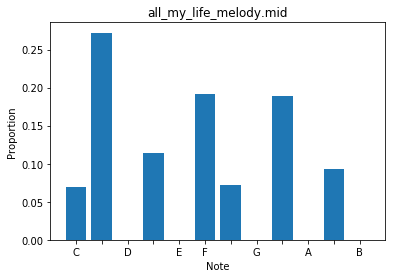

In [237]:
pm = pretty_midi.PrettyMIDI(midi_files[0])
make_graph(pm)
plt.title(midi_files[0])

make_harmony(pm)
#IPython.display.Audio(pm.synthesize(fs=16000), rate=16000)

#Repetitive 4 -> 1 movement

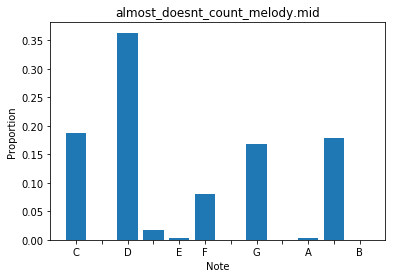

In [238]:
pm = pretty_midi.PrettyMIDI(midi_files[1])
make_graph(pm)
plt.title(midi_files[1])

make_harmony(pm)
#IPython.display.Audio(pm.synthesize(fs=16000), rate = 16000)

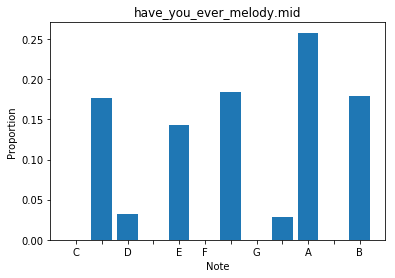

In [239]:
pm = pretty_midi.PrettyMIDI(midi_files[2])
make_graph(pm)
plt.title(midi_files[2])

make_harmony(pm)
#IPython.display.Audio(pm.synthesize(fs=16000), rate = 16000)

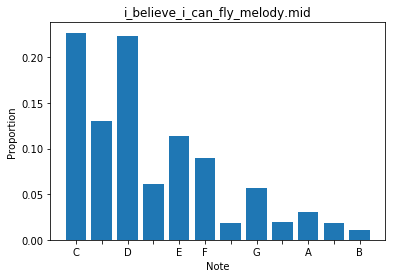

In [240]:
pm = pretty_midi.PrettyMIDI(midi_files[3])
make_graph_weighted(pm)
plt.title(midi_files[3])

make_harmony(pm)
#IPython.display.Audio(pm.synthesize(fs=16000), rate=16000)

#Sounds ok, gets right the 4 -> flat7 movement in original

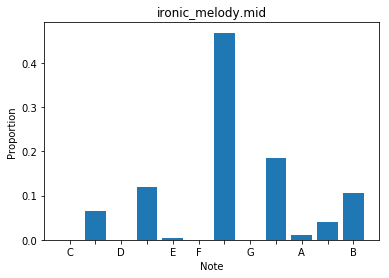

In [241]:
pm = pretty_midi.PrettyMIDI(midi_files[4])
make_graph_weighted(pm)
plt.title(midi_files[4])

make_harmony(pm)
#IPython.display.Audio(pm.synthesize(fs=16000), rate=16000)

#Weird one

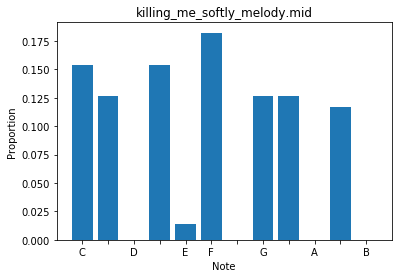

In [242]:
pm = pretty_midi.PrettyMIDI(midi_files[5])
make_graph(pm)
plt.title(midi_files[5])

make_harmony(pm)
#IPython.display.Audio(pm.synthesize(fs=16000), rate = 16000)

#Interesting...

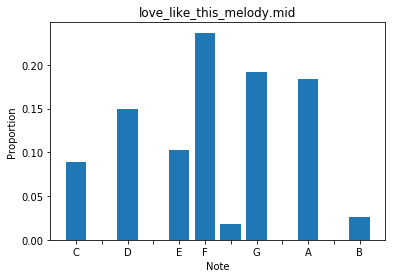

In [243]:
pm = pretty_midi.PrettyMIDI(midi_files[6])
make_graph(pm)
plt.title(midi_files[6])

make_harmony(pm)
#IPython.display.Audio(pm.synthesize(fs=16000), rate = 16000)

#Great!

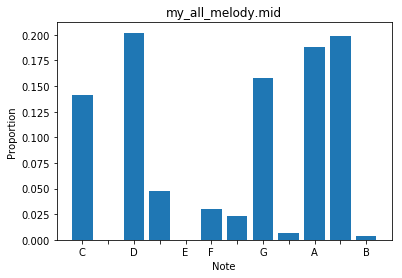

In [244]:
pm = pretty_midi.PrettyMIDI(midi_files[7])
make_graph(pm)
plt.title(midi_files[7])

make_harmony(pm)
#IPython.display.Audio(pm.synthesize(fs=16000), rate = 16000)

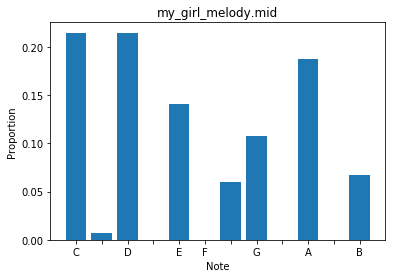

In [245]:
pm = pretty_midi.PrettyMIDI(midi_files[8])
make_graph(pm)
plt.title(midi_files[8])

make_harmony(pm)
#IPython.display.Audio(pm.synthesize(fs=16000), rate = 16000)

# mostly 1, and then 4 -> b7 -> 1

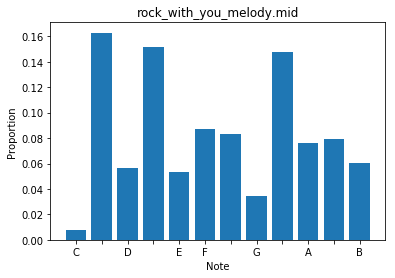

In [246]:
pm = pretty_midi.PrettyMIDI(midi_files[9])
make_graph(pm)
plt.title(midi_files[9])

make_harmony(pm)
#IPython.display.Audio(pm.synthesize(fs=16000), rate = 16000)

#Minor reharmonization?

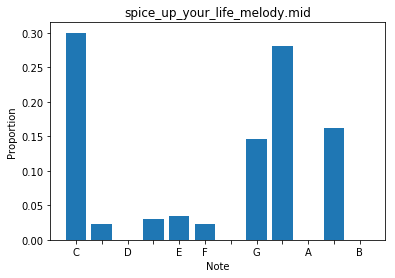

In [247]:
pm = pretty_midi.PrettyMIDI(midi_files[10])
make_graph(pm)
plt.title(midi_files[10])

make_harmony(pm)
#IPython.display.Audio(pm.synthesize(fs=16000), rate = 16000)

#Same note whole time :-(

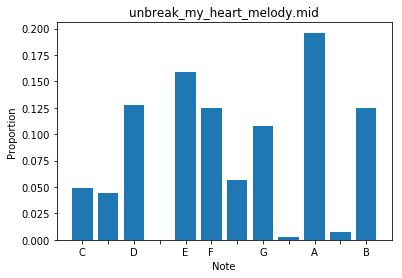

In [248]:
pm = pretty_midi.PrettyMIDI(midi_files[11])
make_graph(pm)
plt.title(midi_files[11])

make_harmony(pm)
#IPython.display.Audio(pm.synthesize(fs=16000), rate = 16000)

#Gets stuck on a bunch of 1 midway through but then breaks out of it

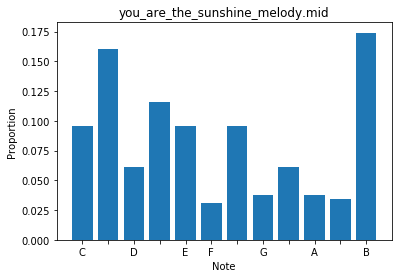

In [249]:
pm = pretty_midi.PrettyMIDI(midi_files[12])
make_graph(pm)
plt.title(midi_files[12])

make_harmony(pm)
#IPython.display.Audio(pm.synthesize(fs=16000), rate = 16000)